In [1]:
# Recurrent neural network (RNN)? 

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 5070 Ti Laptop GPU (UUID: GPU-6c7ec0d6-4306-1156-ccee-4f26d00c9bfd)


In [3]:
import tensorflow as tf

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
from helpers import compare_history,create_tensorboard_callback , plot_loss_curves, create_early_stopping_callback, create_model_checkpoint_callback

In [6]:
## Dataset : Kaggle's introduction to NLP dataset 
# Text samples of tweets labeled as disaster or not disaster

# https://www.kaggle.com/competitions/nlp-getting-started/data

In [7]:
import pandas as pd 
import numpy as np 

In [8]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [9]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
## Visualize nlp dataset
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [12]:
## Shuffle training dataframe 
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [13]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [14]:
len(train_df_shuffled), len(test_df)

(7613, 3263)

In [15]:
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [16]:
## https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [17]:
# Visualize some random training data 
import random 

random_indexes = random.sample(range(len(train_df_shuffled)), 10)

In [18]:
random_indexes

[6519, 6980, 6143, 2834, 1539, 5015, 2009, 7026, 6998, 3225]

In [19]:
train_df_shuffled[['text', 'target']].loc[random_indexes]

,text,target
6519,Now realized I honestly can't survive without ...,0
6980,Just stop fucking saying ÛÏa whole Û÷nother...,0
6143,@tomarse99 they all are intending to go. Just ...,1
2834,? The Circular Ruins - Displaced part 4 ? http...,0
1539,Explosion at chemical site leads to building c...,1
5015,Hope Dorett's 'mudslide' cake wins?? #GBBO,0
2009,Does homeowners insurance cover water damage? ...,1
7026,abcnews - Obama Declares Disaster for Typhoon-...,1
6998,@briannafrost Twister with Bill Paxton and Hel...,0
3225,#Healthcare #Job in #Kodiak AK: Emergency Serv...,0


In [20]:
for index in random_indexes:
    text = train_df_shuffled.loc[index, "text"]
    target = train_df_shuffled.loc[index, "target"]
    label = "Real disaster" if target > 0 else "Not a real disaster"

    print(
        f"Text : \n{text}\n"
        f"Target : {target}\n"
        f"{label}\n"
        "------------"
    )

Text : 
Now realized I honestly can't survive without these glasses now lol
Target : 0
Not a real disaster
------------
Text : 
Just stop fucking saying ÛÏa whole Û÷notherÛ. It just sounds fucking stupid. You fucking mean ÛÏa whole otherÛ. Not a fucking tongue-twister.
Target : 0
Not a real disaster
------------
Text : 
@tomarse99 they all are intending to go. Just waiting for winds to drop. Siren just gone off to signal they allowed to leave arena.none gone
Target : 1
Real disaster
------------
Text : 
? The Circular Ruins - Displaced part 4 ? http://t.co/Od2ratxRqS #nowplaying
Target : 0
Not a real disaster
------------
Text : 
Explosion at chemical site leads to building collapse near Krefeld Germany. Emergency crews on scene; avoid the area. #iJETalerts
Target : 1
Real disaster
------------
Text : 
Hope Dorett's 'mudslide' cake wins?? #GBBO
Target : 0
Not a real disaster
------------
Text : 
Does homeowners insurance cover water damage? Here are some good things to know. htt

In [21]:

from sklearn.model_selection import train_test_split

X = train_df_shuffled.text.to_numpy() # We need numpy array for tensorflow input
y = train_df_shuffled.target.to_numpy()

train_sentences, val_sentences, train_labels, val_labels = train_test_split(X,
                                                                           y, 
                                                                           test_size=0.1,
                                                                           random_state=42)

In [22]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [23]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Converting text into numbers (Tokenization and Embedding) 

Ways to convert text into numbers

1. Tokenization - Vectorazition
    a. direct mapping - word level tokenization  (tokem - words - chars to numbers)
    b. char level tokenization
    c. sub-word tokenization
2. One hot encoding for every words / Not applicable for very large texts

3. Creating embedding (Every words into a vector) - Richer representation of relationships between tokens - can be limit size and can be learned) 

In [24]:
train_sentences[:15]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt',
       'Lava Dragon Breeder! I just bred a 

In [25]:
# word2vec - definitely needs to read 
# Glow embeddings - https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab

## Process of tokenization 

1. Standardize each sample (usually lowercase + puctiation stripping)
2. Split each sample into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
4. Index tokens (associte a unique int value with each token)
5. Transform each sample using this index, either into a vector of ints or a dense float vector

- **Read** https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [26]:
## Text Vectorization (tokenization) 

import tensorflow as tf 
from keras.layers import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=None,  # Defines how many words in the vocabulary, automatically add <OOV> out of vocabulary . if we set it to 10000 it takes modes common 10K and will add <OOV> for others
    standardize="lower_and_strip_punctuation", # default is lower_and_strip_punctuation
    split="whitespace", 
    ngrams=None, # Create group of n-words 
    output_mode='int', 
    output_sequence_length=None, # How long do you want your sequence to bee
    pad_to_max_tokens=False # 
)

In [27]:
len(train_sentences[0].split())

7

In [28]:
# Find the average number of tokens (words) in the training tweets 

round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [29]:
# Setup text vectorization variables 

max_vocab_length = 15000 # max number of words to have in our vocabulary 
max_length = 20 # max length our sequences will be (e.g. how many word from a Tweet does model see?) 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, 
                                   output_mode='int', 
                                   output_sequence_length=max_length)


In [30]:
# fit the text_vectorizer to trianing set 

text_vectorizer.adapt(train_sentences)

In [31]:
# create a sample sentence and tokenize it 
sample_sentence = "There is a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]])>

In [32]:
# Choose random sentence from training dataset and tokenize it 

random_sentence = random.choice(train_sentences) 
print(f"Original text : \n {random_sentence}\
        \n\n Vectorized Version : \n {text_vectorizer([random_sentence])}")

Original text : 
 Plains All American Pipeline company may have spilled 40% more crude oil than previously estimated #KSBYNews @lilitan http://t.co/PegibIqk2w        

 Vectorized Version : 
 [[ 2348    44   692  2803  1218   133    24  4557   354    51  5881   254
     76  2786  2470 11546 11353 13609     0     0]]


In [33]:
# Get the unique words in the vocabulary 

words_in_vocab = text_vectorizer.get_vocabulary() # Get all of the unique words in our training data 
top_5_words = words_in_vocab[:5]  # Get the most common words 
bottom_5_words = words_in_vocab[-5:]  # Get the least used 5 words 

print(f"Number of words in vocab: {len(words_in_vocab)}") 
print(f"Most common 5 words:\n {top_5_words}") 
print(f"Least common 5 words : \n {bottom_5_words}") 

# [UNK] -> unknown -> there is a word outside of 10000 words. 

Number of words in vocab: 15000
Most common 5 words:
 ['', '[UNK]', 'the', 'a', 'in']
Least common 5 words : 
 ['httptcoe7fn5g5ruu', 'httptcoe65v80fcus', 'httptcoe61x9y65qd', 'httptcoe5cns6ufpa', 'httptcoe4ydbm4dx6']


# Create Embeddings instead of Tokenization - Vectorization using EmbeddingLayer layer

- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

- Parameters we care most about for EmbeddingLayer

1. `input_dim` : size of the vocabulary
2. `output_dim` : size of the output embedding vector. e.g. a value of 100 would mean each token gets represented by a vector 100 long
3. `input_length` : length of the sequences being passed to the embedding layer. 

In [34]:
from keras import layers
embedding = layers.Embedding(
    input_dim=max_vocab_length, # set input shape
    output_dim=128, # Output shape
    input_length=max_length, # how long is each input, 
    embeddings_initializer='uniform'
)
embedding

<Embedding name=embedding, built=False>

In [35]:
random_sentence = random.choice(train_sentences) 
tokenized_sentence = text_vectorizer([random_sentence]) 
embedded_sentence = embedding(tokenized_sentence)
print(f"Original Text :\n{random_sentence} \
        \n\nVectorized version : \n{tokenized_sentence}\
        \n\nEmbedded version : \n {embedded_sentence}")

Original Text :
I stand alone
don't piss and moan
about my choices made
If I must reap the whirlwind so be it
I'll do so with demeanor calm and staid         

Vectorized version : 
[[    8   807   910    63  9762     7 10755    54    13  4011   299    47
      8   455  2758     2   411    28    21    15]]        

Embedded version : 
 [[[-0.03542347  0.0132921   0.03651385 ... -0.00190519  0.04049467
    0.04280848]
  [-0.00402588  0.01522504 -0.03696372 ...  0.03236717  0.03452754
    0.01145004]
  [-0.03344851  0.00248146 -0.02330551 ...  0.04872778  0.01601562
   -0.04107006]
  ...
  [ 0.02704083  0.03663066 -0.03304361 ...  0.03974317 -0.01345525
    0.00786146]
  [-0.03757931 -0.01447363  0.01991973 ...  0.04526435 -0.02765839
   -0.01561395]
  [-0.00298526 -0.04764327 -0.00725149 ...  0.00440351 -0.04972155
   -0.02929604]]]


In [36]:
tokenized_sentence

<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[    8,   807,   910,    63,  9762,     7, 10755,    54,    13,
         4011,   299,    47,     8,   455,  2758,     2,   411,    28,
           21,    15]])>

In [37]:
embedded_sentence

<tf.Tensor: shape=(1, 20, 128), dtype=float32, numpy=
array([[[-0.03542347,  0.0132921 ,  0.03651385, ..., -0.00190519,
          0.04049467,  0.04280848],
        [-0.00402588,  0.01522504, -0.03696372, ...,  0.03236717,
          0.03452754,  0.01145004],
        [-0.03344851,  0.00248146, -0.02330551, ...,  0.04872778,
          0.01601562, -0.04107006],
        ...,
        [ 0.02704083,  0.03663066, -0.03304361, ...,  0.03974317,
         -0.01345525,  0.00786146],
        [-0.03757931, -0.01447363,  0.01991973, ...,  0.04526435,
         -0.02765839, -0.01561395],
        [-0.00298526, -0.04764327, -0.00725149, ...,  0.00440351,
         -0.04972155, -0.02929604]]], dtype=float32)>

In [38]:
embedded_sentence[0][0], embedded_sentence[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.03542347,  0.0132921 ,  0.03651385, -0.00047455,  0.04377277,
        -0.0291812 ,  0.02853287,  0.04773377,  0.03622599, -0.03098151,
        -0.04797624,  0.00185952,  0.00418017, -0.00380539,  0.0450008 ,
         0.00561438,  0.02059947,  0.00148457, -0.03448442, -0.00058   ,
         0.00799563, -0.00411521, -0.00983907, -0.027002  , -0.02647161,
         0.02419854, -0.02224246, -0.01610372, -0.00314365,  0.03592599,
         0.00495858,  0.03448374, -0.03707581, -0.0406729 ,  0.01573667,
         0.04578874,  0.00121454,  0.03366207, -0.02136831, -0.02391622,
        -0.01166576, -0.02057778, -0.02025719, -0.02809598,  0.02280854,
         0.01202999, -0.02806766, -0.01561185, -0.02364563, -0.04318595,
         0.00033553,  0.04251728,  0.04042448,  0.03083308,  0.03446135,
         0.02070415, -0.01528807,  0.00199379, -0.03094288,  0.0186483 ,
         0.00186496, -0.03059714,  0.0057102 , -0.01742189, -0.00242854,
  

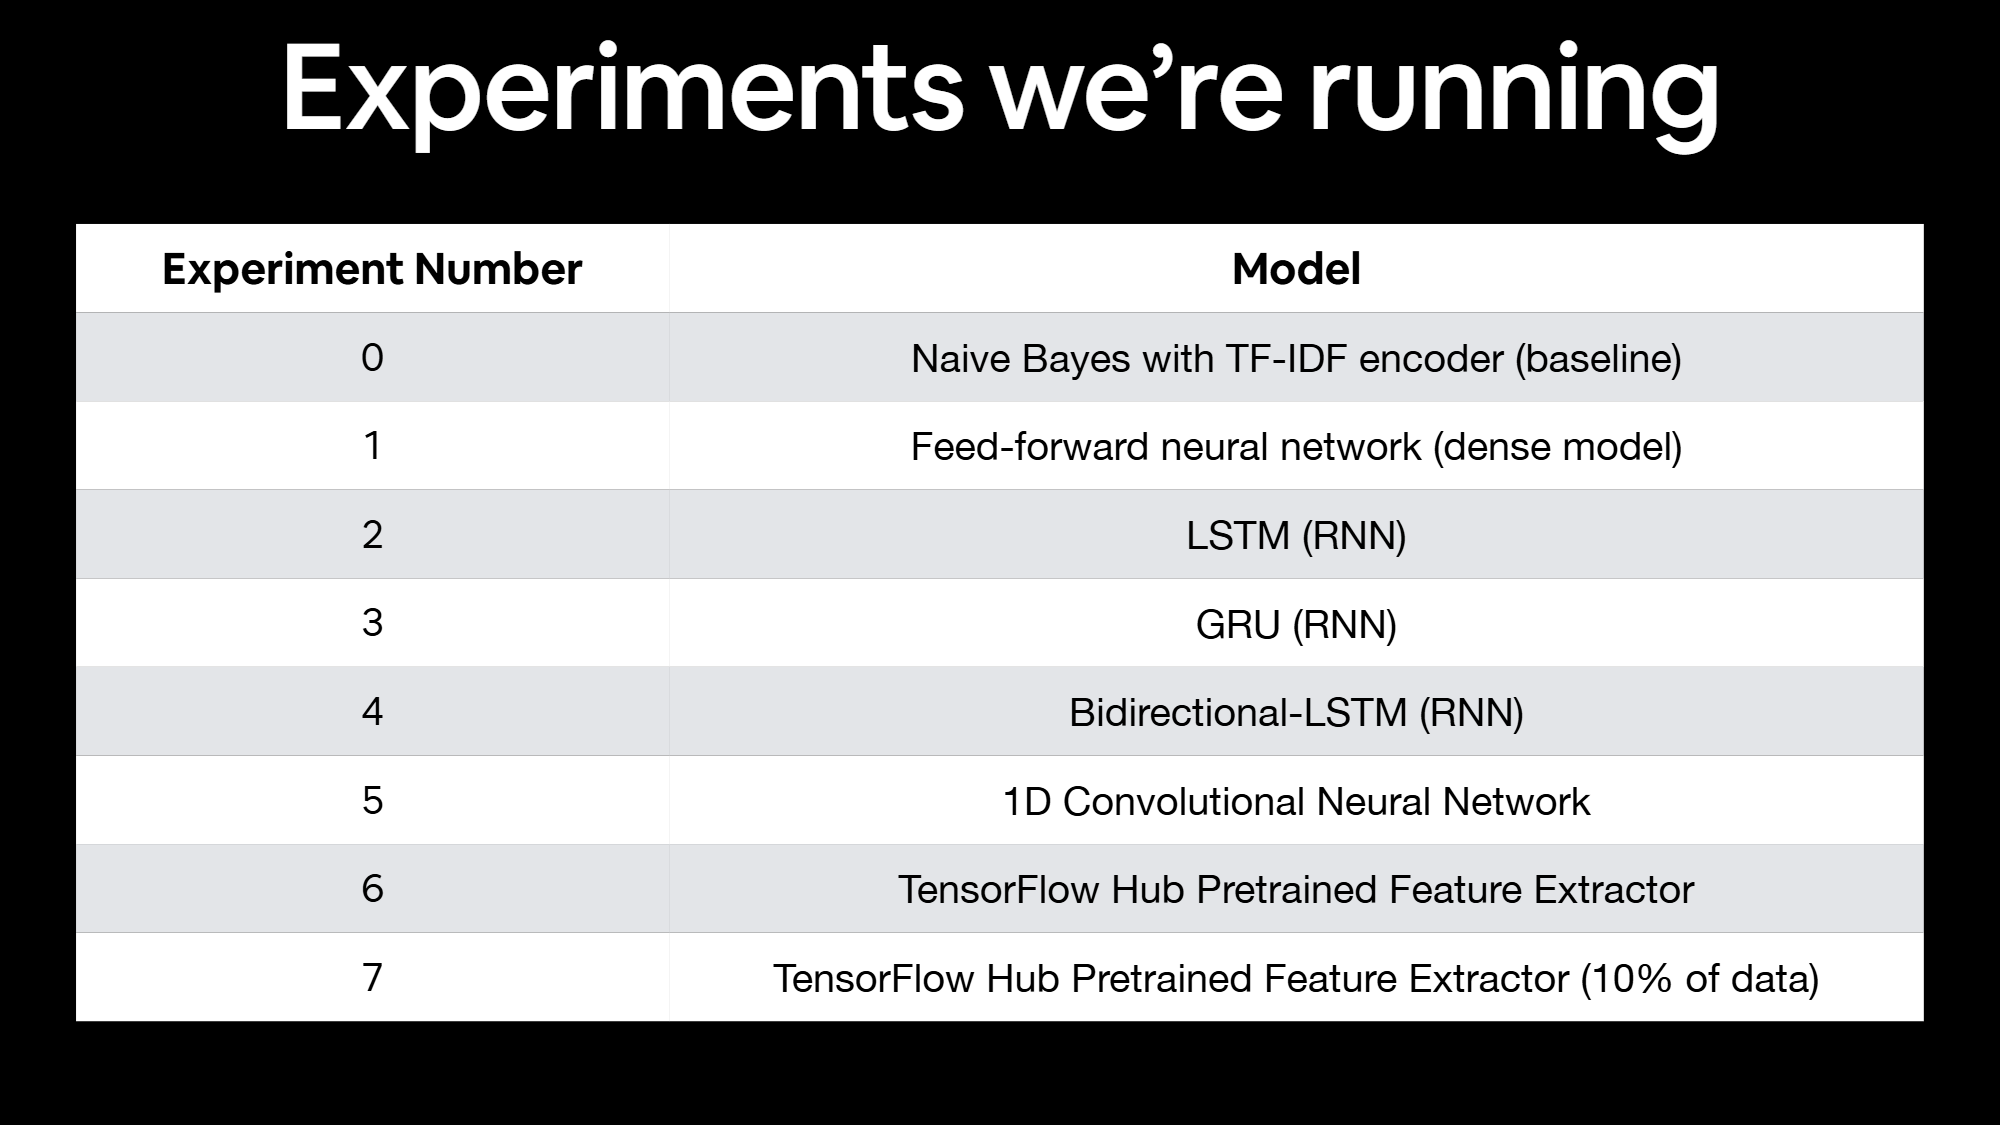

In [39]:
from IPython.display import display, Image

display(Image(filename='nlp-experiments.png'))  # Supports PNG, JPG, etc.


# Experiments : 

1. Model 0: Naive Bayes with TF-IDF encoder (baseline) - We will use sklearn model https://scikit-learn.org/stable/machine_learning_map.html
2. Model 1 : feed forward neural network (dense model)
3. Model 2 : LSTM (RNN)
4. Model 3 : GRU (RNN)
5. Model 4 : Bidirectional-LSTM Model
6. Model 5 : 1D Convolutional Neural Network (CNN)
7. Model 6 : Tensprflow Hub Pretrained Feature Extraction (Using transfer learning)
8. Model 7 : Same model as with 10% of the tranining data 

In [43]:
# Model-0 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),  # converts words to numbers using tfidf
    ("clf", MultinomialNB())   # Model the text 
]) 

# Fit the pipeline to the training data 

model_0.fit(
    train_sentences, 
    train_labels
)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [44]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of : {baseline_score * 100:.2f}%")

Our baseline model achieves an accuracy of : 79.27%


In [45]:
model_0_preds = model_0.predict(val_sentences)
model_0_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score, precision_recall_fscore_support
import seaborn as sns 
import matplotlib.pyplot as plt

def calculate_model_metrics(y_true, y_pred):

    model_precision, model_recall, model_f1, _= precision_recall_fscore_support(y_true=val_labels, y_pred=model_0_preds, average='weighted')
    
    return {
        'accuracy': accuracy_score(y_true, y_pred), 
        'f1': model_f1, 
        'recall': model_recall, 
        'precision': model_precision
    }

model_0_metrics = calculate_model_metrics(y_true=val_labels, y_pred=model_0_preds)

model_0_metrics


{'accuracy': 0.7926509186351706,
 'f1': 0.7862189758049549,
 'recall': 0.7926509186351706,
 'precision': 0.8111390004213173}

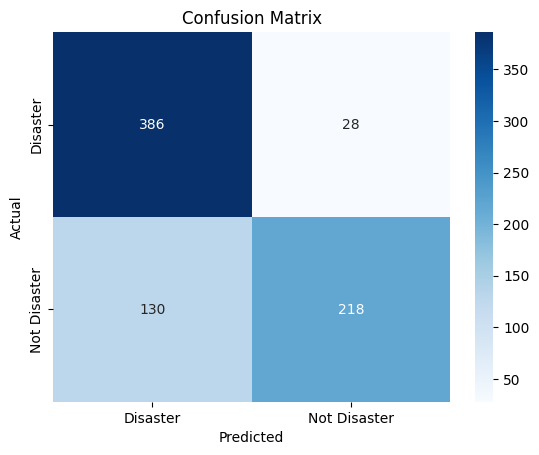

In [47]:
conf_matrix = confusion_matrix(val_labels, model_0_preds)
class_names = ["Disaster", "Not Disaster"]
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d',
            cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names
           )
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')
plt.show();

In [48]:
model_precision, model_recall, model_f1, _= precision_recall_fscore_support(y_true=val_labels, y_pred=model_0_preds, average='weighted')

In [49]:
model_precision

0.8111390004213173

# Model-1 Feed Forward Neural Network (Dense Model) - Experiment-2

A Feedforward Neural Network (FFNN) is a basic type of artificial neural network where information moves in only one direction, from input through hidden layers to the output, with no loops or feedback, making it ideal for pattern recognition, classification, and prediction tasks like image recognition, speech processing, and forecasting. Data flows sequentially, with neurons in one layer connected to every neuron in the next, processing data using weighted sums and activation functions to learn complex patterns without retaining past inputs. 
How It Works
Input Layer: Receives raw data, with each neuron representing a feature.
Hidden Layers: One or more layers where neurons process inputs (weighted sums) and apply activation functions to learn complex patterns.
Output Layer: Produces the final result (e.g., a classification, a prediction).
Data Flow: Information moves forward, layer by layer, never backward.
Learning: The network adjusts its internal weights (via methods like backpropagation) to minimize errors between its output and the actual target. 

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = layers.TextVectorization(max_tokens=max_vocab_length,
                                        output_mode='int',
                                        output_sequence_length=max_length)(inputs)

x= layers.Embedding(input_dim=text_vectorizer.vocabulary_size(),
                    output_dim=128,
                    name="embedding")(text_vectors)

# x = layers.GlobalAveragePooling1D(name="GlobalAveragePooling1D")(x) 
x = layers.GlobalMaxPool1D(name="GlobalMaxPool1D")(x) 
outputs = layers.Dense(1, activation='sigmoid')(x) 

model_1 = keras.Model(inputs, outputs, name='model_1_dense')

model_1.layers[1].adapt(train_sentences)


model_1.compile(
    loss=keras.losses.BinaryCrossentropy(), 
    optimizer=keras.optimizers.Adam(), 
    metrics=['accuracy']
)

model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 128)           1920000   
                                                                 
 GlobalMaxPool1D (GlobalMax  (None, 128)               0         
 Pooling1D)                                                      
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1920129 (7.32 MB)
Trainable params: 192

In [51]:
history_1 = model_1.fit(
    x=train_sentences,
    y=train_labels, 
    validation_data=(val_sentences, val_labels), 
    epochs=5, 
    verbose=1, 
    callbacks=[
        create_tensorboard_callback(
            dir_name="/workspace/tensorflow/tensorboard/", 
            experiment_name="nlp_simple_dense_model"
        )
    ]
)

Saving TensorBoard log files to /workspace/tensorflow/tensorboard/nlp_simple_dense_model/20260102-022019
Epoch 1/5
215/215 [==============================] - 5s 18ms/step - loss: 0.6380 - accuracy: 0.6510 - val_loss: 0.5796 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4732 - accuracy: 0.8283 - val_loss: 0.4780 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3384 - accuracy: 0.8821 - val_loss: 0.4495 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2467 - accuracy: 0.9152 - val_loss: 0.4509 - val_accuracy: 0.8031
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1805 - accuracy: 0.9418 - val_loss: 0.4612 - val_accuracy: 0.8031


In [52]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4612 - accuracy: 0.8031


[0.46122628450393677, 0.8031495809555054]

In [53]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.28223217],
       [0.83686185],
       [0.9936429 ],
       [0.05479046],
       [0.34161294],
       [0.9697723 ],
       [0.96363586],
       [0.989869  ],
       [0.9396217 ],
       [0.11868532]], dtype=float32)

In [54]:
model_1_pred_probs.shape

(762, 1)

In [55]:
model_1_preds= np.round(np.squeeze(model_1_pred_probs)).astype(int)

In [56]:
model_1_metrics = calculate_model_metrics(y_true=val_labels, 
                                         y_pred=model_1_preds)

model_1_metrics

{'accuracy': 0.8031496062992126,
 'f1': 0.7862189758049549,
 'recall': 0.7926509186351706,
 'precision': 0.8111390004213173}

In [57]:
model_0_metrics

{'accuracy': 0.7926509186351706,
 'f1': 0.7862189758049549,
 'recall': 0.7926509186351706,
 'precision': 0.8111390004213173}

In [58]:
np.array(list(model_1_metrics.values())) > np.array(list(model_0_metrics.values()))

array([ True, False, False, False])

In [59]:
## Visualize learned embeddings  
weights = model_1.get_layer("embedding").get_weights()[0]
vocab = text_vectorizer.get_vocabulary()

In [60]:
import io 
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [61]:
vocab[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

## Recurrent Neural Networks
Famous Recurrent Layers: 
1. LSTM,
2. GRU,
3. Bidirectional


* Typical structure of RNNs:

Input (Text) -> Tokenize -> Embedding -> Layers (RNNs/Dense) -> Output (Label probability)

In [62]:
text_vectorizer = tf.keras.layers.TextVectorization(
                                max_tokens=10000,
                                standardize='lower_and_strip_punctuation',
                                split='whitespace',
                                output_mode='int',
                                output_sequence_length=15)

embedding = tf.keras.layers.Embedding(input_dim=10000,
                             output_dim=128,
                             embeddings_initializer='uniform',
                             name="embedding")

In [63]:
## Model-2 LSTM -> Long Short Term Memory 



inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
text_vectors = text_vectorizer(inputs) 
x = embedding(text_vectors)

print(x.shape)

# We need to set return_sequences=True when we stack multiple LSTM layers except on the last LSTM layer

x = tf.keras.layers.LSTM(64, return_sequences=True)(x)

print(x.shape)

# x = tf.keras.layers.LSTM(64, return_sequences=True)(x) 
# print(x.shape)

x = tf.keras.layers.LSTM(64)(x) 
print(x.shape)


x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


model_2.summary()

model_2.layers[1].adapt(train_sentences)

model_2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)



(None, 15, 128)
(None, 15, 64)
(None, 64)
Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
            

In [64]:
# Compile (already done)
# Limit GPU memory

history_2 = model_2.fit(
    x=train_sentences, 
    y=train_labels, 
    validation_data=(val_sentences, val_labels), 
    epochs=5, 
    callbacks=[
        create_tensorboard_callback(
            dir_name="/workspace/tensorflow/tensorboard/", 
            experiment_name="model_2_LSTM"
        )
    ]
)

Saving TensorBoard log files to /workspace/tensorflow/tensorboard/model_2_LSTM/20260102-022032
Epoch 1/5


InternalError: Graph execution error:

Detected at node CudnnRNN defined at (most recent call last):
<stack traces unavailable>
Failed to call DoRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 128, 64, 1, 15, 32, 64] 
	 [[{{node CudnnRNN}}]]
	 [[model_2_LSTM/lstm/PartitionedCall]] [Op:__inference_train_function_16616]